<a href="https://colab.research.google.com/github/TeemuMikkonen/Dataxq/blob/main/Solita_x_Manager.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

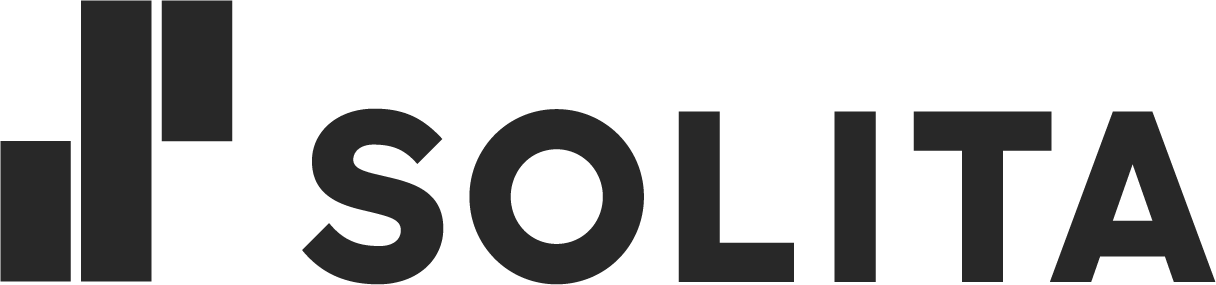


## Google Colaboratory

- Googlen ylläpitämä ilmainen Notebook-palvelu
- Helppo jakaa koodia ja työskennellä yhdessä mm. dataprojekteissa. (Tai harkkatöissä)
- Saatavilla myös laskentatehoa (GPU & TPU -prosessointi)
  >- Yläpalkki
  >- Runtime
  >- Change runtime type
  >- Hardware accelerator
  >- GPU 

- Tähän harjoitukseen ei kuitenkaan tarvita lisälaskentatehoa, datamäärät ovat pieniä ja käytettävät kirjastot eivät vaadi GPU-resursseja
- HUOM. Saatavat laskentaresurssit riippuvat vapaana olevasta kapasiteetista, laskentateho ei näin ollen ole vakio. 

#### Hyödyllisiä pikakomentoja
> - ctrl/cmd + enter = suorita solu
> - shift + enter = suorita solu ja siirry seuraavaan
> - ctrl/cmd + m + b = luo solu alapuolelle
> - ctrl/cmd + m + a = luo solu yläpuolelle
> - ctrl/cmd + d + d = poista solut


## Case: Asiakaspoistuman ennustaminen (Customer churn)
- Klassinen Data Science -esimerkkicase
- Dataprojekti, joka alkaa raakadatan vastaanottamisesta, käsittelystä ja tietokantaan kirjoittamisesta ja lopputuotteesta, joka tässä projektissa on asiakaspoistumaa ennustava koneoppimismalli

In [ ]:
import requests as r
import json
import pandas as pd
import os
import plotly.express as px
from sklearn.metrics import classification_report, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

In [ ]:
!pip install awscli
"AWScli asennettu"

'AWScli asennettu'

## Datan kerääminen

Data luetaan AWS-pilvitarjoajan S3-bucketista. Simple Storage Service (S3) on tapa säilöä rakenteetonta dataa, kuten tiedostoja, kuvia, videoita jne.

Data Engineerin työsarka alkaa datan keräämisestä. Yleinen menetelmä datan siirtoon lähdejärjestelmästä, on kirjoittaa se tiedostoon S3-bucketin tyyppiseen tallennustilaan, josta se voidaan lukea haluttuun muotoon esimerkiksi Pythonin tai ELT/ETL-työkalun avulla

In [ ]:
#Haetaan data S3-bucketista COLABin hakemistorakenteeseen

!aws s3 --no-sign-request cp s3://manager-dataxq/ . --recursive

download: s3://manager-dataxq/data/telecom_churn_20201021_1.csv to data/telecom_churn_20201021_1.csv
download: s3://manager-dataxq/data/telecom_churn_20201021_2.csv to data/telecom_churn_20201021_2.csv
download: s3://manager-dataxq/data/d_account.csv to data/d_account.csv
download: s3://manager-dataxq/data/telecom_churn_20201021_3.csv to data/telecom_churn_20201021_3.csv


# Eksploratiivinen analyysi

Data Engineerin / Data Scientistin työssä dataan tutustuminen on tärkeää. Data voi poiketa paljonkin siitä, minkälaiseksi asiakas on sen kuvannut. Vaikka datan sisältö olisi dokumentoitu, dokumentointi ei välttämättä pidä sisällään tietoa siitä, käytetäänkö kaikkia kenttiä asianmukaisesti.

Tutkitaan mitä dataa hakemistosta luettiin, ja mitä tiedostot pitävät sisällään

In [ ]:
!ls data

d_account.csv  telecom_churn_20201021_1.csv  telecom_churn_20201021_3.csv
data	       telecom_churn_20201021_2.csv


### Pandas DataFrame
DataFrame on 


In [ ]:
# Luetaan tiedosto Pandas D
df_exp = pd.read_csv("data/telecom_churn_20201021_1.csv")

print("Rivejä: ", df_exp.shape[0], "Sarakkeita", df_exp.shape[1], "\n")
df_exp.head()

Rivejä:  1000 Sarakkeita 16 



,account_id,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls,Churn
0,10001,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,10002,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,10003,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,10004,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,10005,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False


Luettu data sisältää myös dimensiotaulun "account". Dimensiotaulut liitetään faktaan yhteisen ID:n avulla

In [ ]:
df_dim = pd.read_csv("data/d_account.csv")

print("Rivejä: ", df_dim.shape[0], "Sarakkeita", df_dim.shape[1], "\n")
df_dim.head()

Rivejä:  3333 Sarakkeita 6 



,account_id,State,Account length,Area code,International plan,Voice mail plan
0,10001,KS,128,415,No,Yes
1,10002,OH,107,415,No,Yes
2,10003,NJ,137,415,No,No
3,10004,OH,84,408,Yes,No
4,10005,OK,75,415,Yes,No


# Datasetin muodostus ja siivous

Asiakaspoistuma-analyysissä käytettävä data on jaettu useaan tiedostoon. Tämä voi olla esimerkiksi lähdejärjestelmän ja S3-bucketin välisen ETL:n ominaisuus, jossa määritellään tiedostoista halutun kokoisia, jolloin esimerkiksi latausaikoja on helpompi arvioida. 

Luetaan faktataulu telecom_churn yhteen DataFrameen

In [ ]:
df_churn = pd.concat([pd.read_csv("data/" + i) for i in os.listdir("data") if i.startswith("telecom")])
df_churn.head()

,account_id,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls,Churn
0,12001,0,168.2,87,28.59,161.7,92,13.74,192.4,112,8.66,10.1,3,2.73,3,False
1,12002,0,286.4,109,48.69,178.2,67,15.15,214.2,152,9.64,10.7,14,2.89,1,True
2,12003,0,174.3,95,29.63,186.6,128,15.86,258.2,105,11.62,12.9,5,3.48,3,False
3,12004,0,190.6,100,32.40,161.7,104,13.74,189.9,136,8.55,13.0,6,3.51,1,False
4,12005,0,175.5,86,29.84,205.1,78,17.43,245.2,100,11.03,17.8,3,4.81,4,False


Tästä voidaan huomata, että df_dim- ja df_churn -dataframet käyttävät samaa avainta (account_id) Taulut voidaan siis yhdistää kyseisen avaimen avulla yhdeksi tauluksi. Yhdistämiseen käytetään df.join()-komentoa, jota käytetään hyvin samaan tyyliin kuin esimerkiksi SQL:n join-komentoa

In [ ]:
df = df_dim.join(df_churn.set_index('account_id'), on='account_id', how="left")
df.head()

,account_id,State,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls,Churn
0,10001,KS,128,415,No,Yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,10002,OH,107,415,No,Yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,10003,NJ,137,415,No,No,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,10004,OH,84,408,Yes,No,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,10005,OK,75,415,Yes,No,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False


In [ ]:
total_calls = (
    df["Total day calls"]
    + df["Total eve calls"]
    + df["Total night calls"]
    + df["Total intl calls"]
)
df.insert(loc=len(df.columns), column="Total calls", value=total_calls)


In [ ]:
df.head()

,account_id,State,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls,Churn,Total calls
0,10001,KS,128,415,No,Yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False,303
1,10002,OH,107,415,No,Yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False,332
2,10003,NJ,137,415,No,No,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False,333
3,10004,OH,84,408,Yes,No,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False,255
4,10005,OK,75,415,Yes,No,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False,359


In [ ]:
churns = df.loc[df["Churn"] == True ]
# suhdeluku osavaltioittain kaikki asiakkaat /churnatut

states = churns["State"].value_counts(normalize = True)
import plotly.express as px
fig = px.choropleth(locations=states.index,
                    locationmode="USA-states",
                    color=states, scope="usa")
  
fig.show()

# Datan kirjoittaminen tietokantaan

Data Engineering -projektien työnkulku on hyvin usein tiedostojen datasisällön lukeminen, käsitteleminen ja kirjoittaminen relaatiotietokantaan. 

Tässä vaiheessa luodaan SQLite-tietokanta, jonne luodaan taulut d_account ja f_churn

In [ ]:
import sqlite3
from sqlite3 import Error

def create_connection(db_file):
    """ create a database connection to a SQLite database """
    conn = None
    try:
        conn = sqlite3.connect(db_file)
        print("Connection succesful")
    except Error as e:
        print(e)
    
    return conn


db_name = "customer_churn.db"
create_connection(db_name)

Connection succesful


In [ ]:
def write_db(df, table):

    db_name = "customer_churn.db"
    try:
        conn = sqlite3.connect(db_name)
        df.to_sql(table, con = conn, if_exists = "replace", index = False)
        print("Insert Successful to table: " + table)
        
    except sqlite3.Error as e:
        print(e)
    conn.close()

write_db(df_churn, "f_customer_churn")
write_db(df_dim, "d_account")


Insert Successful to table: f_customer_churn
Insert Successful to table: d_account


/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:2615: UserWarning:

The spaces in these column names will not be changed. In pandas versions < 0.14, spaces were converted to underscores.



## Tietokantakysely

Data on nyt kirjoitettu tietokantaan. Dataa voidaan nyt kysellä SQL-lauseilla alla olevan funktion avulla

In [ ]:
def query_db(sql):
  try:
    conn = sqlite3.connect(db_name)
    query = conn.cursor().execute(sql)
    cols = [column[0] for column in query.description]

    results = pd.DataFrame.from_records(data = query.fetchall(), columns = cols)
    display(results)
  except sqlite3.Error as e:
    print(e)

  conn.close()

query_db("SELECT * FROM d_account acc LEFT JOIN f_customer_churn cc on acc.account_id = cc.account_id")

,account_id,State,Account length,Area code,International plan,Voice mail plan,account_id,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls,Churn
0,10001,KS,128,415,No,Yes,10001,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,0
1,10002,OH,107,415,No,Yes,10002,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,0
2,10003,NJ,137,415,No,No,10003,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,0
3,10004,OH,84,408,Yes,No,10004,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,0
4,10005,OK,75,415,Yes,No,10005,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3328,13329,AZ,192,415,No,Yes,13329,36,156.2,77,26.55,215.5,126,18.32,279.1,83,12.56,9.9,6,2.67,2,0
3329,13330,WV,68,415,No,No,13330,0,231.1,57,39.29,153.4,55,13.04,191.3,123,8.61,9.6,4,2.59,3,0
3330,13331,RI,28,510,No,No,13331,0,180.8,109,30.74,288.8,58,24.55,191.9,91,8.64,14.1,6,3.81,2,0
3331,13332,CT,184,510,Yes,No,13332,0,213.8,105,36.35,159.6,84,13.57,139.2,137,6.26,5.0,10,1.35,2,0


# Asiakaspoistuman ennustemalli

Ennustemallia varten muodostetaan datasetti, jota voidaan käyttää koneoppimismallin koulutuksessa. Muodostetaan kaksi DataFramea df_churn -dataFramesta:
- X sisältää asiakasdatan 
- Y sisältää tiedon siitä, onko ko. asiakas keskeyttänyt asiakkuuden

In [ ]:
 X = df_churn.drop(["Churn", "account_id"], axis = 1)
 y = df_churn["Churn"]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [ ]:

classifier = RandomForestClassifier(n_estimators=200, random_state=0)  
classifier.fit(X_train, y_train)  
predictions = classifier.predict(X_test)

In [ ]:

print(classification_report(y_test,predictions ))  
print("Accuracy:",(accuracy_score(y_test, predictions )))

              precision    recall  f1-score   support

       False       0.93      0.99      0.96       581
        True       0.88      0.52      0.66        86

    accuracy                           0.93       667
   macro avg       0.91      0.76      0.81       667
weighted avg       0.93      0.93      0.92       667

Accuracy: 0.9295352323838081


# Miten ennustemallin tunnuslukuja luetaan
 - Precision
 - Recall
 - Accuracy

 Minkä takia pelkkä accuracy voi olla harjaanjohtava mittari? Vinkki: Tarkista asiakaspoistumaaineiston jakauma

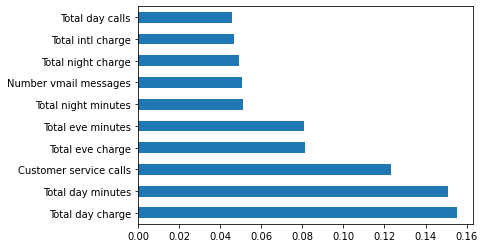

In [ ]:
feat_importances = pd.Series(classifier.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh')

# New Section

In [ ]:
# TODO case ympärille
# validationsetti

# miten tätä käytetään, kysymyksenä